In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
# Pandas set option (floating display)
pd.set_option('display.float_format', lambda x: '%.3f' %x)

# Set random seed, will be using sub samples
RANDOM_SEED = 100

# Visualizations options
plt.rcParams['font.size'] = 12
palette = sns.color_palette('Paired', 10)

In [4]:
import pickles

train_set = pd.read_pickle("./pickles/train_set.pkl")
test_set = pd.read_pickle("./pickles/test_set.pkl")

## Modeling

Notes:
- We will start with simple models. We could use this as a baseline and simple models are often the way to go. We want our models to be generalizable to other data sets, not just our training set

`train_test_split`
- We will be using the train_test_split to create a validation set. From there, we are going to stratify - meaning, we will use our target variable to get a similar distribution of our dataset to our train_test_split sets

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(train_set, np.array(train_set['fare_amount']), 
                                                      stratify=train_set['fare-bin'],
                                                      random_state=RANDOM_SEED, test_size=1_000_000)

### Scoring Metrics

For the validation set for assessing the model. We'll use two metrics:
1. Root mean squared error: the metric used by the competition
2. Mean absolute percentage error: the average percentage error of the predictions

In [48]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics: Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

### Submission

In [49]:
def make_submission(ids, predicts, cols_headers, csv_name):
    col_1, col_2 = cols_headers
    sub = pd.DataFrame({col_1: ids, col_2: predicts})
    sub.to_csv(csv_name, index=False)
    return sub
    

### Baseline

Notes:
- We will not how well our model is doing if we do have a baseline to compare it to. A naive way and efficient way to do is by calculating the averages

In [50]:
# Establishing our baseline using averages
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

Baseline Training:   rmse = 9.45 	 mape = 65.02
Baseline Validation: rmse = 9.46 	 mape = 65.03


### Linear Regression
Variables: `abs_diff_lat`, `abs_diff_long`, and `passenger_count`

In [51]:
# Creating a variable for the linear regression
lr = LinearRegression()

In [52]:
# Training a simple (only using three methods)

lr.fit(X_train[['abs_diff_lat', 'abs_diff_long', 'passenger_count']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 
      '\tabs_lon_diff coef:', round(lr.coef_[1], 4),
      '\tpassenger_count coef:', round(lr.coef_[2], 4))


Intercept 5.0067
abs_lat_diff coef:  114.8487 	abs_lon_diff coef: 165.1105 	passenger_count coef: 0.048


Notes
- Positive influences from the three variables. E.g. for every new passenger, people should expect to pay 0.04 more

In [53]:
# Evaluating our linear regression model
evaluate(lr, ['abs_diff_lat', 'abs_diff_long', 'passenger_count'], X_train, X_valid, y_train, y_valid)

Training:   rmse = 5.41 	 mape = 28.09
Validation: rmse = 5.42 	 mape = 28.02


Notes
- Notice that this an improvement to simply using training_set averages

In [54]:
# Linear Regression predicting the testing set
preds = lr.predict(test_set[['abs_diff_lat', 'abs_diff_long', 'passenger_count']])
sub_lr_simple = make_submission(test_id, preds, ['key', 'fare_amount'], "./submissions/sub_lr_simple.csv")

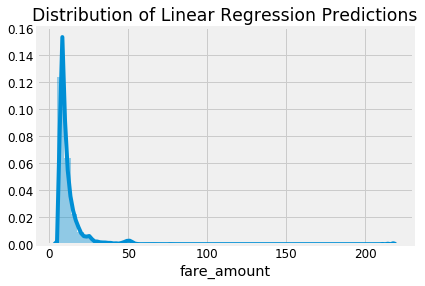

In [55]:
# Distribution of the testing set prediction
sns.distplot(sub_lr_simple['fare_amount'])
plt.title('Distribution of Linear Regression Predictions');

Notes:
- After reading some other competitors, they pointed out is to be careful for large fare_amount values. Any predictions that are far off will have an outsized effect on the error

In [56]:
# Viewing people prediction were larger than 100 dollars
test_set.loc[sub_lr_simple[sub_lr_simple['fare_amount'] > 100].index]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_long,abs_diff_lat,Manhattan_dist,Euclidean_dist,Haverstine_dist
4080,2010-06-11 13:37:21,-73.137,41.366,-73.984,40.733,1,0.847,0.633,1.480,1.057,100.106
5887,2010-07-04 16:44:11,-73.137,41.366,-73.983,40.767,1,0.845,0.599,1.444,1.036,97.348
8529,2009-11-25 19:32:52,-73.137,41.366,-73.987,40.758,3,0.849,0.608,1.457,1.044,98.300


In [57]:
# Values over 100, will keep an eye on
sub_lr_simple[sub_lr_simple['fare_amount'] > 100]

,key,fare_amount
4080,2010-06-11 13:37:21.0000004,217.586
5887,2010-07-04 16:44:11.0000002,213.395
8529,2009-11-25 19:32:52.0000001,215.205


In [58]:
# Storing the index of values over 100
simple_over_100 = list(sub_lr_simple[sub_lr_simple['fare_amount'] > 100].index)
sub_lr_simple['fare_amount'].describe()

count   9914.000
mean      11.484
std        8.176
min        5.055
25%        7.438
50%        9.091
75%       12.362
max      217.586
Name: fare_amount, dtype: float64

## Modeling: Make it More Complicated

Added more features

Variables: `abs_diff_lat`, `abs_diff_long`, `passenger_count`, `Haverstine_dist`

In [59]:
lr.fit(X_train[['Haverstine_dist', 'abs_diff_lat', 'abs_diff_long', 'passenger_count']], y_train)
evaluate(lr, ['Haverstine_dist', 'abs_diff_lat', 'abs_diff_long', 'passenger_count'], X_train, X_valid, y_train, y_valid)

Training:   rmse = 5.1 	 mape = 24.61
Validation: rmse = 5.1 	 mape = 24.56


In [60]:
print(lr.intercept_)
print(lr.coef_)

4.500738179252851
[ 4.27160033e+00 -2.41255604e+02 -1.03581247e+02  4.18661171e-02]


### Colinear Features

Notes:
- Features that are highly correlated with one another. This can decrease the performance of our model. Also, it can decrease the interability...

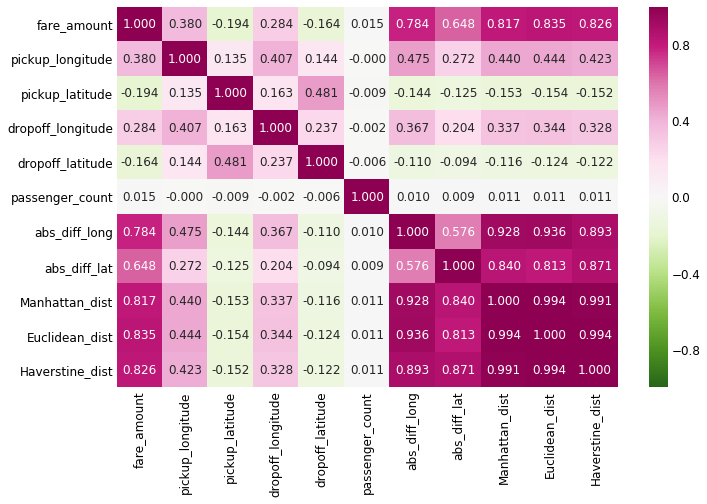

In [61]:
# Correlation Matrix
corrs = train_set.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corrs, annot=True, vmin=-1, vmax=1, fmt='.3f', cmap=plt.cm.PiYG_r);

## Modeling: Make it More Complicated

Using more complicated models

In [62]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest, (these are the default hyperparameters)
rf = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

In [63]:
# Train on data
rf.fit(X_train[['Haverstine_dist', 'abs_diff_lat', 'abs_diff_long', 'passenger_count']], y_train)

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.8min finished
/Users/alexguanga/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)

In [64]:
# Evaluate the model
evaluate(rf, ['Haverstine_dist', 'abs_diff_lat', 'abs_diff_long', 'passenger_count'],
         X_train, X_valid, y_train, y_valid)


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   14.7s finished


Training:   rmse = 3.65 	 mape = 20.52
Validation: rmse = 4.27 	 mape = 22.17


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.3s finished


Notes:
- Since our score improved, we are hinted that the relationship is not solely linear. 
- Take notice between the rmse for the training and validation set. This indicates that the model is bias towards the training.

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.1s finished


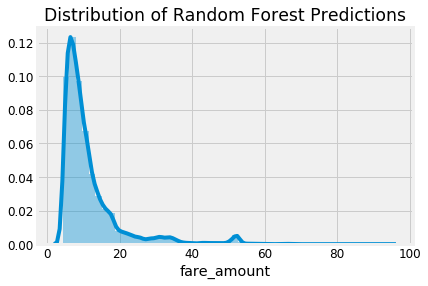

In [65]:
# Predictions
preds = rf.predict(test_set[['Haverstine_dist', 'abs_diff_lat', 'abs_diff_long', 'passenger_count']])
sub_rf = make_submission(test_id, preds, ['key', 'fare_amount'], "./submissions/sub_rf.csv")

# Distribution of the testing set prediction
sns.distplot(sub_rf['fare_amount'])
plt.title('Distribution of Random Forest Predictions');

In [66]:
sub_rf[sub_rf['fare_amount'] > 100]

,key,fare_amount


Notes:
- With the Random Forest Regressor, we do not witness the same problem as with the more simple models

## Modeling: Averaging Models

Will average the random forest and linear regression model

In [67]:
# Predicting the training set
lr_train_pred = lr.predict(X_train[['Haverstine_dist', 'abs_diff_lat', 'abs_diff_long', 'passenger_count']])
rf_train_pred = rf.predict(X_train[['Haverstine_dist', 'abs_diff_lat', 'abs_diff_long', 'passenger_count']])

# Predicting the validation set
lr_pred = lr.predict(X_valid[['Haverstine_dist', 'abs_diff_lat', 'abs_diff_long', 'passenger_count']])
rf_pred = rf.predict(X_valid[['Haverstine_dist', 'abs_diff_lat', 'abs_diff_long', 'passenger_count']])

# Average predictions
train_pred = (lr_train_pred+rf_train_pred)/2
valid_pred = (lr_pred+rf_pred)/2

# Calculating our performance metrics
tr, vr, tm, vm = metrics(train_pred, valid_pred, y_train, y_valid)

print(f'Combined Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Combined Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.4s finished


Combined Training:   rmse = 4.16 	 mape = 22.07
Combined Validation: rmse = 4.46 	 mape = 22.84


## Modeling: Use More Features

In [68]:
def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 20, max_depth = 20,
                                           n_jobs = -1),
             return_model = False):
    """Train and evaluate the random forest using the given set of features."""
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    evaluate(model, features, X_train, X_valid, y_train, y_valid)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False).set_index('feature')
    
    if return_model:
        return sub, feature_importances, model
    
    return sub, feature_importances

In [69]:
# Evaluate using 8 features

sub_rf_feats8, fi_rf_feats8 = model_rf(X_train, X_valid, y_train, y_valid, test_set, 
                                       features = ['abs_diff_lat', 'abs_diff_long', 'Haverstine_dist', 
                                                   'passenger_count', 'pickup_latitude', 'pickup_longitude', 
                                                   'dropoff_latitude', 'dropoff_longitude'])


Training:   rmse = 3.1 	 mape = 18.41
Validation: rmse = 3.74 	 mape = 20.03


### Feature Importance

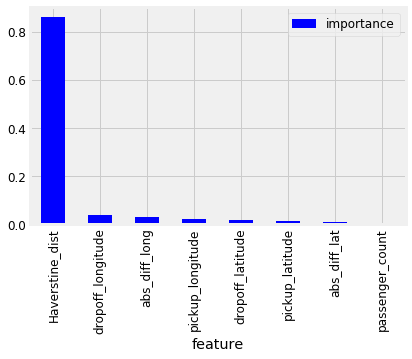

In [70]:
fi_rf_feats8.plot.bar(color='b')

Notes:
- `Haverstine_dist` is the most important feature
- Lets look further into distance

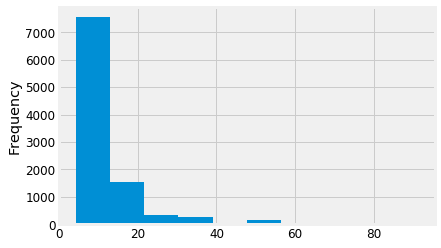

In [71]:
# Create submission
sub_rf_feats8.to_csv("./submissions/sub_rf_feats8.csv", index=False)
sub_rf_feats8['fare_amount'].plot.hist();


## Modeling: Use More Features

- We still have not used the date features. 
- Based on the kernel, they suggest we use the fastai module for time variables that we could extract from a date variable
- https://github.com/fastai/fastai/blob/master/fastai/structured.py

In [72]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date (and time) Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [73]:
# We need to figure the value for start_time
# We will be using the training set for the start time referenc

print(train_set['pickup_datetime'].min())
print(test_set['pickup_datetime'].min())

2009-01-01 00:00:46
2009-01-01 11:04:24


In [74]:
test_set = extract_dateinfo(test_set, 'pickup_datetime', drop=False, time=True, 
                            start_ref=train_set['pickup_datetime'].min())
test_set.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_long,abs_diff_lat,Manhattan_dist,Euclidean_dist,...,pickup_is_leap_year,pickup_Hour,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed
0,2015-01-27 13:08:24,-73.973,40.764,-73.981,40.744,1,0.008,0.020,0.028,0.022,...,False,13,8,24,365,0.547,0.221,0.861,0.075,191596058.000
1,2015-01-27 13:08:24,-73.987,40.719,-73.999,40.739,1,0.012,0.020,0.032,0.023,...,False,13,8,24,365,0.547,0.221,0.861,0.075,191596058.000
2,2011-10-08 11:53:44,-73.983,40.751,-73.980,40.746,1,0.003,0.005,0.008,0.006,...,False,11,53,44,365,0.496,0.785,0.265,0.769,87306778.000
3,2012-12-01 21:12:12,-73.981,40.768,-73.990,40.752,1,0.009,0.016,0.025,0.019,...,True,21,12,12,366,0.883,0.840,0.059,0.918,123628286.000
4,2012-12-01 21:12:12,-73.966,40.790,-73.989,40.744,1,0.023,0.045,0.068,0.051,...,True,21,12,12,366,0.883,0.840,0.059,0.918,123628286.000


In [75]:
train_set = extract_dateinfo(train_set, 'pickup_datetime', drop=False, time=True, 
                             start_ref=train_set['pickup_datetime'].min())
train_set.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_long,abs_diff_lat,Manhattan_dist,Euclidean_dist,...,pickup_Days_in_month,pickup_Hour,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed
count,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,...,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000,4893381.000
mean,11.294,-73.975,40.751,-73.974,40.751,1.685,0.023,0.021,0.044,0.034,...,30.427,13.511,29.573,15.858,365.160,0.584,0.518,0.519,0.480,101421942.743
std,9.449,0.039,0.030,0.038,0.033,1.308,0.035,0.024,0.053,0.040,...,0.835,6.515,17.328,19.437,0.367,0.272,0.278,0.276,0.286,58401147.212
min,2.500,-74.989,40.034,-74.998,40.006,0.000,0.000,0.000,0.000,0.000,...,28.000,0.000,0.000,0.000,365.000,0.000,0.000,0.031,0.003,0.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000,0.006,0.007,0.016,0.013,...,30.000,9.000,15.000,0.000,365.000,0.393,0.271,0.281,0.234,51213254.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000,0.013,0.014,0.028,0.022,...,31.000,14.000,30.000,4.000,365.000,0.611,0.529,0.517,0.458,101261375.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000,0.024,0.027,0.051,0.039,...,31.000,19.000,45.000,32.000,365.000,0.814,0.755,0.754,0.732,151324783.000
max,120.000,-72.063,41.923,-72.067,41.998,6.000,1.919,1.271,2.133,1.920,...,31.000,23.000,59.000,59.000,366.000,1.000,1.000,1.000,1.000,204940697.000


`time_elapsed`

/Users/alexguanga/anaconda/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


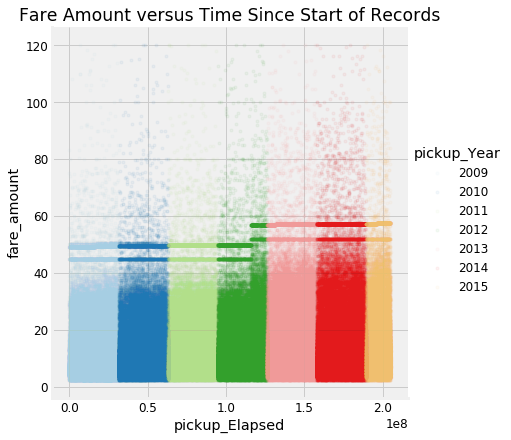

In [76]:
# Plotting the time elapse, has the fare changed over time
sns.lmplot('pickup_Elapsed', 'fare_amount', hue="pickup_Year", palette=palette, size=6,
           scatter_kws={'alpha': 0.05}, markers='.', fit_reg=False,
           data=train_set.sample(1000000, random_state=RANDOM_SEED));

plt.title('Fare Amount versus Time Since Start of Records');

Notes:
- Slight increase in the fare_amount throughout the year

`pickup_Hour`

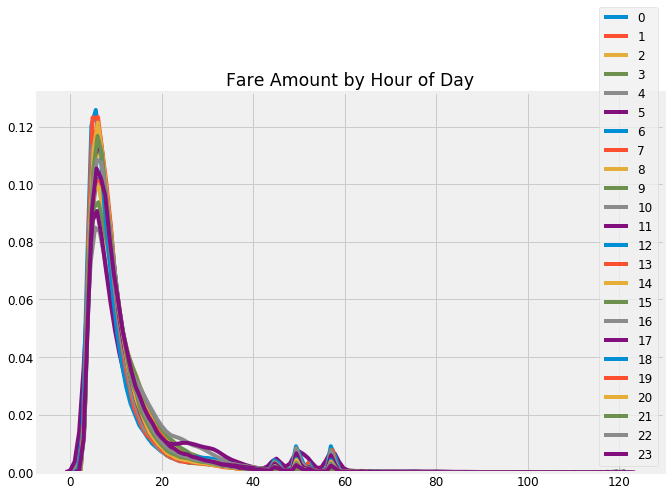

In [77]:
plt.figure(figsize=(10, 7))

for hour_label, grouped in train_set.groupby('pickup_Hour'):
    sns.kdeplot(grouped['fare_amount'], label=f'{hour_label}')
                
plt.title('Fare Amount by Hour of Day');

`pickup_Dayofweek`

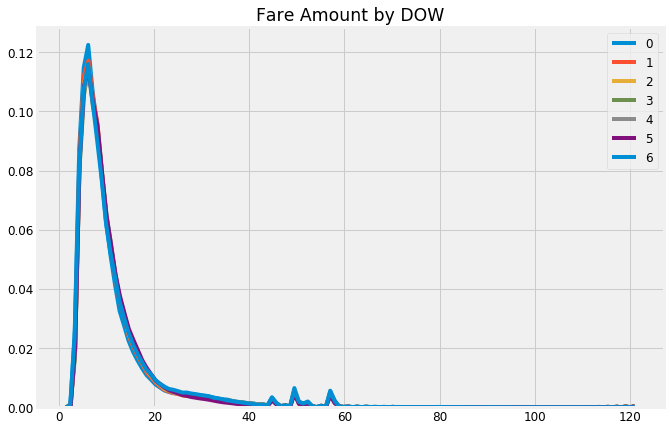

In [78]:
plt.figure(figsize=(10, 7))

for hour_label, grouped in train_set.groupby('pickup_Dayofweek'):
    sns.kdeplot(grouped['fare_amount'], label=f'{hour_label}')
                
plt.title('Fare Amount by DOW');

Notes:
- DOW and Hours do not convery much information

**Fractional Times**

In [79]:
train_set.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare-bin',
       'color', 'abs_diff_long', 'abs_diff_lat', 'Manhattan_dist',
       'Euclidean_dist', 'Haverstine_dist', 'pickup_Year', 'pickup_Month',
       'pickup_Week', 'pickup_Day', 'pickup_Dayofweek', 'pickup_Dayofyear',
       'pickup_Days_in_month', 'pickup_is_leap_year', 'pickup_Hour',
       'pickup_Minute', 'pickup_Second', 'pickup_Days_in_year',
       'pickup_frac_day', 'pickup_frac_week', 'pickup_frac_month',
       'pickup_frac_year', 'pickup_Elapsed'],
      dtype='object')

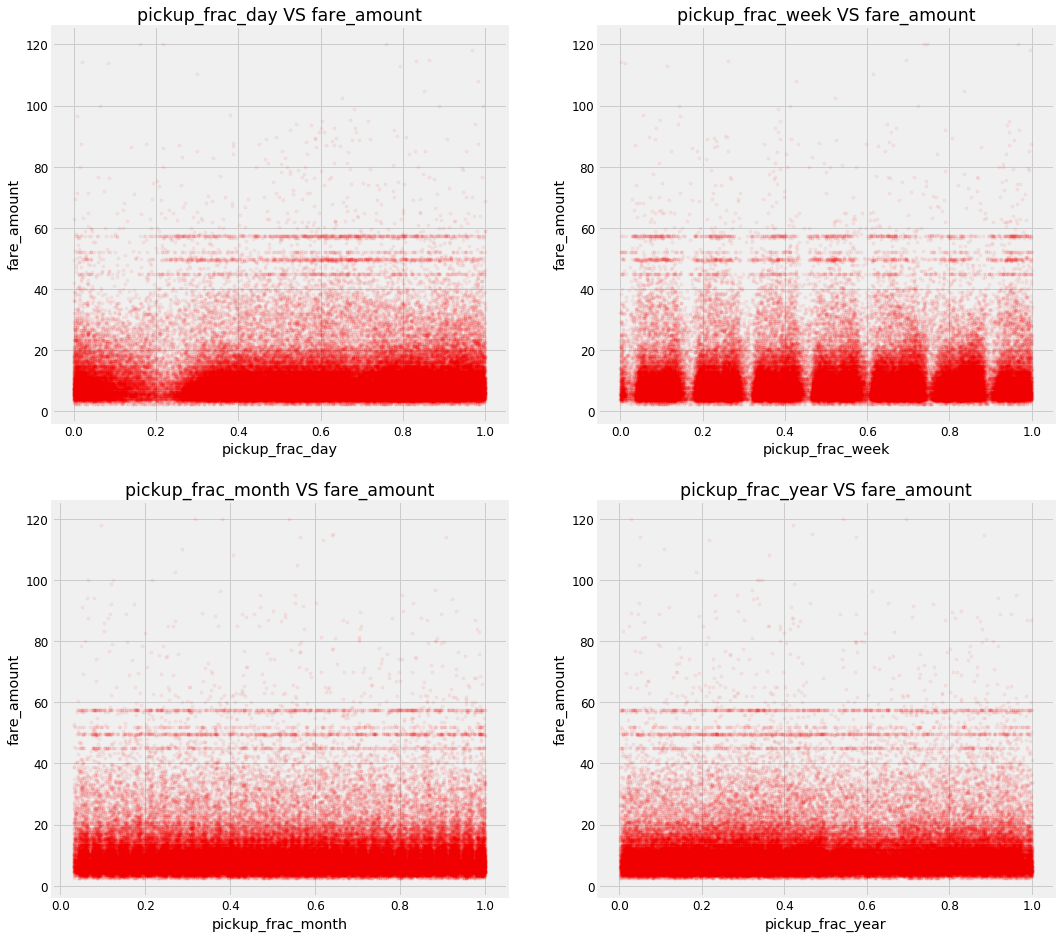

In [80]:
fig, axes = plt.subplots(2,2, figsize=(16, 16))
axes = axes.flatten()

# Plotting the fractional times
fractionals = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_month', 'pickup_frac_year']

for i, col in enumerate(fractionals):
    ax = axes[i]
    sns.regplot(col, 'fare_amount', data=train_set.sample(100_000, random_state=RANDOM_SEED), 
               fit_reg=False, scatter_kws={'alpha': .05}, marker='.', ax=ax, color='r')
    ax.set_title(f'{col} VS fare_amount')

Notes:
- Not much information is conveyed in the graph. One thing to notice is that there are straight lines indicated there's some structured patterns

In [81]:
train_set.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare-bin',
       'color', 'abs_diff_long', 'abs_diff_lat', 'Manhattan_dist',
       'Euclidean_dist', 'Haverstine_dist', 'pickup_Year', 'pickup_Month',
       'pickup_Week', 'pickup_Day', 'pickup_Dayofweek', 'pickup_Dayofyear',
       'pickup_Days_in_month', 'pickup_is_leap_year', 'pickup_Hour',
       'pickup_Minute', 'pickup_Second', 'pickup_Days_in_year',
       'pickup_frac_day', 'pickup_frac_week', 'pickup_frac_month',
       'pickup_frac_year', 'pickup_Elapsed'],
      dtype='object')

In [82]:
# Lets look at the haverstine_dist to confirm or not confirm or hypothesis

fare_counts = train_set.groupby('fare_amount')['Haverstine_dist'].agg(
    ['count', pd.Series.nunique]).sort_values('count', ascending=False)
fare_counts.head(5)   

,count,nunique
fare_amount,,
6.500,238197,235802.000
4.500,201277,198253.000
8.500,183756,182266.000
5.700,143214,141424.000
5.300,143188,141222.000


Notes:
- Notice that we are grouping it based on the haverstine_dist, 
- There are a lot of haverstine for these specific fare_amount
- Moreover, the unique value is quite large

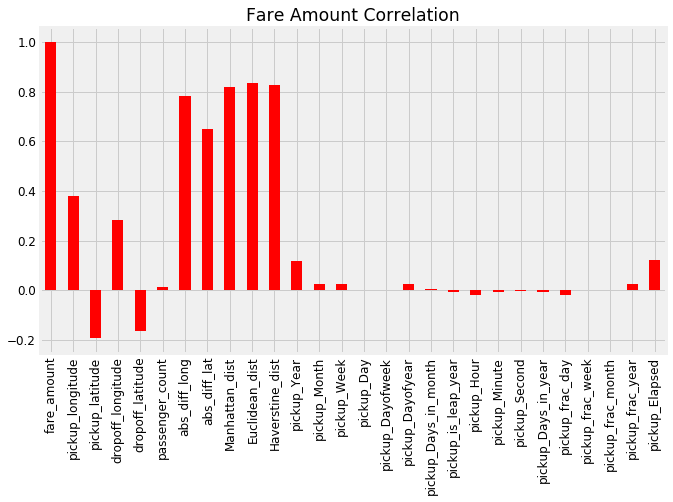

In [83]:
# Correlation
corrs = train_set.corr()
corrs['fare_amount'].plot.bar(color='r', figsize=(10,6))
plt.title('Fare Amount Correlation');

Notes:
- Notice how from the variabls created by the date vairbales, there are two variable that have a decent correlation (positive) with the target variable: `pickup_Year` and `pickup_Elapsed`

## Modeling

In [93]:
X_train, X_valid, y_train, y_valid = train_test_split(train_set, np.array(train_set['fare_amount']), 
                                                      stratify=train_set['fare-bin'],
                                                      random_state=RANDOM_SEED, test_size=1_000_000)

In [94]:
# Added new features

time_features = ['pickup_Elapsed']
features = ['abs_diff_long', 'abs_diff_lat', 'Haverstine_dist', 'passenger_count',
           'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'] + time_features


In [95]:
# Testing the Random Forest

sub_rf_time_fts, fi_rf_time_fts = model_rf(X_train, X_valid, y_train, y_valid, test_set, features=features)

Training:   rmse = 2.76 	 mape = 16.37
Validation: rmse = 3.45 	 mape = 18.03


Notes
- Notice how our model improved when we include the time variable: `pickup_Elapsed`

Text(0.5,1,'Feature Importance for RF Model (using time features)')

<Figure size 720x432 with 0 Axes>

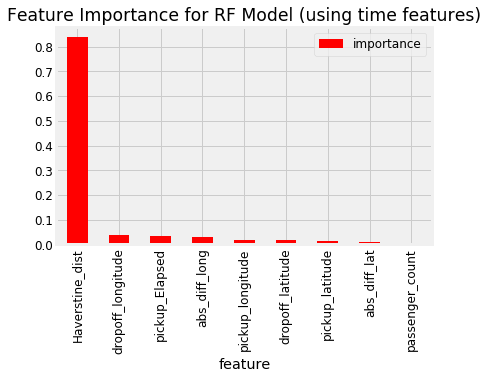

In [98]:
plt.figure(figsize=(10,6))
fi_rf_time_fts.plot.bar(color='r')
plt.title("Feature Importance for RF Model (using time features)")

Notes:
- The `pickup_Elapsed` importance was the third...

In [101]:
# For comparision purposes, we can try to run our model with all the features
features = list(train_set.columns)

# Removing features 
for f in ['pickup_datetime', 'fare_amount', 'fare-bin', 'color']:
    features.remove(f)

len(features)

27

In [116]:
# Running the model with all features

sub_rf_all_fts, fi_rf_all_fts, rf = model_rf(X_train, X_valid, y_train, y_valid, test_set, 
                                             features=features, return_model=True)

Training:   rmse = 2.65 	 mape = 15.47
Validation: rmse = 3.41 	 mape = 17.34


Text(0.5,1,'Important features: All-In')

<Figure size 1080x432 with 0 Axes>

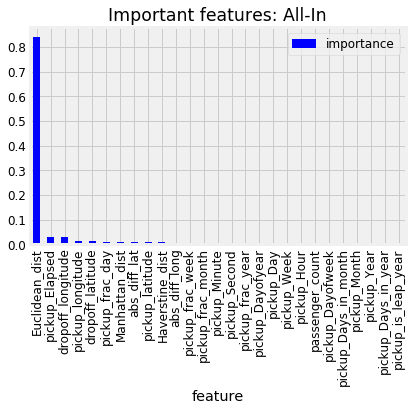

In [119]:
# Most important features
plt.figure(figsize=(15,6));
fi_rf_all_fts.plot.bar(color='b')
plt.title("Important features: All-In")

In [111]:
# Createing the submission file
sub_rf_all_fts.to_csv("./submissions/sub_rf_all_fts.csv", index=False)

## Modeling: Understanding Errors

In [112]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)

Text(0.5,1,'Actual VS Predictions Distribution')

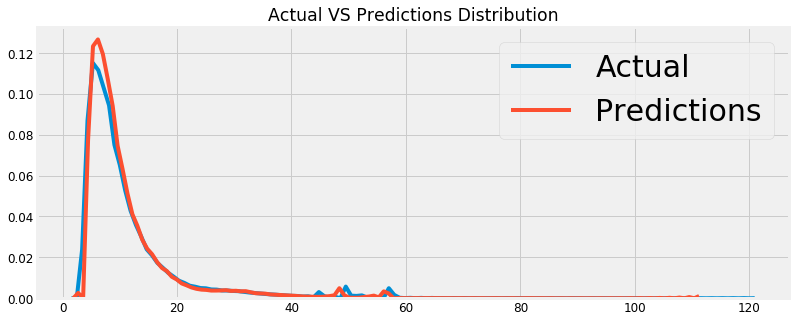

In [118]:
# Understanding our wrong predicitions using validation set predictions
valid_predicts = rf.predict(X_valid[features])

plt.figure(figsize=(12,5))
sns.kdeplot(y_valid, label="Actual")
sns.kdeplot(valid_predicts, label="Predictions")
plt.legend(prop={'size': 30})
plt.title("Actual VS Predictions Distribution")

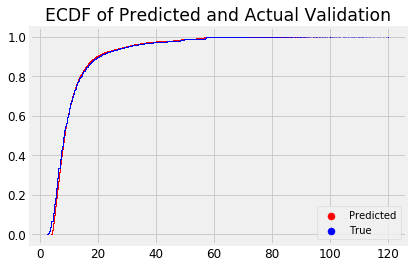

In [121]:
# Generate the ecdf graph -- are there patterns of incorrect predictios
xv, yv = ecdf(valid_predicts)
xtrue, ytrue = ecdf(y_valid)

# Plot the ecdfs on same plot
plt.scatter(xv, yv, s = 0.02,  c = 'r', marker = '.', label = 'Predicted')
plt.scatter(xtrue, ytrue, s = 0.02, c = 'b', marker = '.', label = 'True')
plt.title('ECDF of Predicted and Actual Validation')

plt.legend(markerscale = 100, prop = {'size': 10});

In [122]:
# Explicit comparision btw predicitions and ground_truth
comparision = pd.DataFrame({"Actual": y_valid, "Predictions": valid_predicts})
comparision.describe()

,Actual,Predictions
count,1000000.000,1000000.000
mean,11.296,11.310
std,9.464,8.834
min,2.500,2.776
25%,6.000,6.344
50%,8.500,8.554
75%,12.500,12.458
max,120.000,110.341


## Model: Hyperparameters

We now understand our data. We have a couple models build with different features. Additionally, machine leanring has the flexibility to tune hyperparameters. Meaning, there's still room for improvement, we could still figure out how else we could improve our model

### Random Search

We'll use a basic form of hyperparameter tuning, random search. This means constructing a parameter grid and then randomly selecting combinations of values, evaluating them in cross validation, and determining which combination performs the best. This is quickly done using the `RandomizedSearchCV` in Scikit-Learn

In [123]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 100).astype(int),
    'max_depth': [None] + list(np.linspace(5, 30).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestRegressor(random_state=RANDOM_SEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        n_iter=100, verbose=1, random_state=RANDOM_SEED)

In [125]:
# Using a sample of our training set (computational purposes)
sample_data = train_set.sample(50_000, random_state=RANDOM_SEED)

# Select features 
time_features = ['pickup_Elapsed']
features = ['abs_diff_long', 'abs_diff_lat', 'Haverstine_dist', 'passenger_count',
           'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'] + time_features

rs.fit(sample_data[features], np.array(sample_data['fare_amount']))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=100, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': array([ 10,  11,  13,  15,  17,  19,  21,  22,  24,  26,  28,  30,  32,
        33,  35,  37,  39,  41,  43,  44,  46,  48,  50,  52,  54,  55,
        57,  59,  61,  63,  65,  66,  68,  70,  72,  74,  76,  77,  79,
        81,  83,  85,  87,  88,  90,  92,  94, ...9, 49, 49, 49, 49, 49, 49, 49, 49, 50], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=100, refit=True,
          r

In [126]:
# Best estimators
model = rs.best_estimator_
print(f'The best parameters were {rs.best_params_} with a negative mae of {rs.best_score_}')


The best parameters were {'n_estimators': 41, 'min_samples_split': 2, 'max_leaf_nodes': 49, 'max_features': 0.5, 'max_depth': 22, 'bootstrap': True} with a negative mae of -2.07366073086709


In [127]:
# How does the best estimators perform?

model.n_jobs = -1
model.fit(X_train[features], y_train)

evaluate(model, features, X_train, X_valid, y_train, y_valid)

Training:   rmse = 3.85 	 mape = 21.11
Validation: rmse = 3.83 	 mape = 21.09


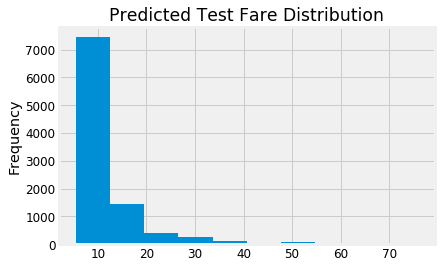

In [128]:
# Submission model
pred = np.array(model.predict(test_set[features]))
sub_rf_tuned = pd.DataFrame({'key': test_id, 'fare_amount': pred})
sub_rf_tuned.to_csv('sub_rf_tuned.csv', index = False)
sub_rf_tuned['fare_amount'].plot.hist();
plt.title('Predicted Test Fare Distribution');


Links:
- https://www.kaggle.com/willkoehrsen/a-walkthrough-and-a-challenge